In [41]:
import os
import glob
import time
import h5py
import skimage
import statistics
import seaborn as sns
from PIL import Image
import numpy as np
import pandas as pd
from skimage import io
from skimage import measure
from skimage.color import rgb2gray
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [42]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
directory = os.getcwd() + '\data_second_cleaned'
print(directory)

x:\Machine Learning\Glucose Estimation\data_second_cleaned


In [44]:
files = glob.glob(directory + '\**\*')
values = [None] * len(files)

x = 0
while x < len(files):
    files[x] = files[x].replace('\\','/')
    temp = files[x][59:]
    values[x] = int(temp[0:temp.index('/')])
    x = x + 1

files = pd.Series(files, name='Filepath')
values = pd.Series(values, name='Glucose')

In [45]:
images = pd.concat([files, values], axis=1)
images

,Filepath,Glucose
0,x:/Machine Learning/Glucose Estimation/data_se...,100
1,x:/Machine Learning/Glucose Estimation/data_se...,100
2,x:/Machine Learning/Glucose Estimation/data_se...,100
3,x:/Machine Learning/Glucose Estimation/data_se...,100
4,x:/Machine Learning/Glucose Estimation/data_se...,100
...,...,...
1123,x:/Machine Learning/Glucose Estimation/data_se...,99
1124,x:/Machine Learning/Glucose Estimation/data_se...,99
1125,x:/Machine Learning/Glucose Estimation/data_se...,99
1126,x:/Machine Learning/Glucose Estimation/data_se...,99


In [46]:
images = images.sample(1128, random_state=7).reset_index(drop=True)
images

,Filepath,Glucose
0,x:/Machine Learning/Glucose Estimation/data_se...,101
1,x:/Machine Learning/Glucose Estimation/data_se...,83
2,x:/Machine Learning/Glucose Estimation/data_se...,83
3,x:/Machine Learning/Glucose Estimation/data_se...,131
4,x:/Machine Learning/Glucose Estimation/data_se...,113
...,...,...
1123,x:/Machine Learning/Glucose Estimation/data_se...,92
1124,x:/Machine Learning/Glucose Estimation/data_se...,111
1125,x:/Machine Learning/Glucose Estimation/data_se...,142
1126,x:/Machine Learning/Glucose Estimation/data_se...,147


In [47]:
#Creating Diferrent Columns for Image Measurements

red_cols = [ 'Red COM' , 'Red Minimum' , 'Red Maximum' , 'Red Median' , 'Red Mean' , 'Red SDT' , 'Red Variance']
green_cols = ['Green COM' , 'Green Minimum' , 'Green Maximum' , 'Green Median' , 'Green Mean' , 'Green SDT' , 'Green Variance']
blue_cols = ['Blue COM' , 'Blue Maximum' , 'Blue Median' , 'Blue Mean' , 'Blue SDT' , 'Blue Variance']
grey_cols = ['Gray COM' , 'Gray Minimum' , 'Gray Median' , 'Gray Mean' , 'Gray SDT' , 'Gray Variance']
rgb_cols = red_cols + green_cols + blue_cols + grey_cols
rgb_cols.append('Inertia Eigen Val1')
rgb_cols.append('Inertia Eigen Val2')
rgb_cols.append('Inertia Eigen Val3')
rgb_cols.append('Glucose')

dataset = pd.DataFrame(columns=rgb_cols,index=range(0,1128))
for col in dataset.columns:
        dataset[col].values[:] = 0
dataset

,Red COM,Red Minimum,Red Maximum,Red Median,Red Mean,Red SDT,Red Variance,Green COM,Green Minimum,Green Maximum,...,Gray COM,Gray Minimum,Gray Median,Gray Mean,Gray SDT,Gray Variance,Inertia Eigen Val1,Inertia Eigen Val2,Inertia Eigen Val3,Glucose
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1124,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1125,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1126,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
#Taking Measurements from All Images

from scipy import ndimage

for i, row in images.iterrows():
    image = io.imread(row['Filepath'])
    rimage = image[:][:][0]
    gimage = image[:][:][1]
    bimage = image[:][:][2]
    grimage = rgb2gray(image)
    rw = dataset.loc[i]
    
    rcom = ndimage.center_of_mass(rimage)
    rext = ndimage.extrema(rimage)
    rw['Red COM'] = rimage[int(rcom[0])][int(rcom[1])].astype('int')
    rw['Red Minimum'] = rext[0].astype('int')
    rw['Red Maximum'] = rext[1].astype('int')
    rw['Red Median'] = ndimage.median(rimage).astype('float')
    rw['Red Mean'] = ndimage.mean(rimage).astype('float')
    rw['Red SDT'] = ndimage.standard_deviation(rimage).astype('float')
    rw['Red Variance'] = ndimage.variance(rimage).astype('float')
    
    gcom = ndimage.center_of_mass(gimage)
    gext = ndimage.extrema(gimage)
    rw['Green COM'] = gimage[int(gcom[0])][int(gcom[1])].astype('int')
    rw['Green Minimum'] = gext[0].astype('int')
    rw['Green Maximum'] = gext[1].astype('int')
    rw['Green Median'] = ndimage.median(gimage).astype('float')
    rw['Green Mean'] = ndimage.mean(gimage).astype('float')
    rw['Green SDT'] = ndimage.standard_deviation(gimage).astype('float')
    rw['Green Variance'] = ndimage.variance(gimage).astype('float')
    
    bcom = ndimage.center_of_mass(bimage)
    bext = ndimage.extrema(bimage)
    rw['Blue COM'] = bimage[int(bcom[0])][int(bcom[1])].astype('int')
    rw['Blue Maximum'] = bext[1].astype('int')
    rw['Blue Median'] = ndimage.median(bimage).astype('float')
    rw['Blue Mean'] = ndimage.mean(bimage).astype('float')
    rw['Blue SDT'] = ndimage.standard_deviation(bimage).astype('float')
    rw['Blue Variance'] = ndimage.variance(bimage).astype('float')
    
    rw['Glucose'] = row['Glucose']
    grimage = rgb2gray(io.imread(row['Filepath']))
    gcom = ndimage.center_of_mass(grimage)
    gext = ndimage.extrema(grimage)
    rw['Gray COM'] = grimage[int(gcom[0])][int(gcom[1])].astype('float')
    rw['Gray Minimum'] = gext[0].astype('float')
    rw['Gray Median'] = ndimage.median(grimage).astype('float')
    rw['Gray Mean'] = ndimage.mean(grimage).astype('float')
    rw['Gray SDT'] = ndimage.standard_deviation(grimage).astype('float')
    rw['Gray Variance'] = ndimage.variance(grimage).astype('float')
    
    eigen = measure.inertia_tensor_eigvals(image)
    rw['Inertia Eigen Val1'] = eigen[0]
    rw['Inertia Eigen Val2'] = eigen[1]
    rw['Inertia Eigen Val3'] = eigen[2]

dataset

,Red COM,Red Minimum,Red Maximum,Red Median,Red Mean,Red SDT,Red Variance,Green COM,Green Minimum,Green Maximum,...,Gray COM,Gray Minimum,Gray Median,Gray Mean,Gray SDT,Gray Variance,Inertia Eigen Val1,Inertia Eigen Val2,Inertia Eigen Val3,Glucose
0,208,3,208,28.0,69.19375,70.44009,4961.806211,201,2,204,...,0.286613,0.108944,0.221771,0.223995,0.043084,0.001856,44860.778426,27688.442773,17173.608727,101
1,210,0,217,27.0,72.615104,75.954518,5769.088834,213,2,218,...,0.291681,0.116994,0.231963,0.23074,0.040048,0.001604,45317.484597,28025.20852,17293.53915,83
2,199,3,210,27.0,69.132292,72.126641,5202.252291,202,2,208,...,0.291115,0.083507,0.229693,0.227091,0.042007,0.001765,44926.359476,27675.657035,17251.903065,83
3,212,0,227,33.0,75.185417,76.531352,5857.047912,216,1,221,...,0.290006,0.09535,0.235983,0.231417,0.041288,0.001705,45189.369901,27853.356484,17337.279645,131
4,193,0,211,28.0,69.139583,71.554243,5120.009683,196,1,207,...,0.295037,0.096399,0.228256,0.227161,0.042021,0.001766,45019.575538,27754.981905,17265.835501,113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,230,0,236,40.5,76.959896,72.864929,5309.297871,227,0,238,...,0.282938,0.036765,0.211998,0.206269,0.054607,0.002982,42647.117635,25705.180695,16943.011057,92
1124,207,0,218,34.0,73.567188,73.933646,5466.184028,206,0,219,...,0.290006,0.102322,0.233347,0.230157,0.042267,0.001787,45089.14448,27803.693898,17286.75233,111
1125,222,0,230,38.5,77.323437,76.795603,5897.564659,226,0,227,...,0.293928,0.072613,0.235794,0.229417,0.043715,0.001911,44897.727238,27572.279582,17326.716681,142
1126,157,1,165,25.0,53.122396,50.497598,2550.007415,149,1,162,...,0.276963,0.055871,0.177514,0.186899,0.054686,0.002991,41822.772525,25432.686761,16391.167655,147


In [49]:
#Dataset Correlation
corr1=dataset.astype(float).corr().iloc[0:29, 29:30]
print(corr1)

                     Glucose
Red COM            -0.085235
Red Minimum         0.076860
Red Maximum        -0.102656
Red Median          0.017256
Red Mean           -0.090315
Red SDT            -0.118300
Red Variance       -0.112353
Green COM          -0.098863
Green Minimum       0.038005
Green Maximum      -0.090201
Green Median        0.011855
Green Mean         -0.095603
Green SDT          -0.119094
Green Variance     -0.113435
Blue COM           -0.093381
Blue Maximum       -0.102849
Blue Median         0.004415
Blue Mean          -0.100426
Blue SDT           -0.119667
Blue Variance      -0.114550
Gray COM           -0.133776
Gray Minimum       -0.131099
Gray Median        -0.156892
Gray Mean          -0.157296
Gray SDT            0.158915
Gray Variance       0.162206
Inertia Eigen Val1 -0.169537
Inertia Eigen Val2 -0.167160
Inertia Eigen Val3 -0.164318


In [50]:
#Dataset Correlation
corr1=dataset.astype(float).corr(method='kendall').iloc[0:29, 29:30]
print(corr1)

                     Glucose
Red COM             0.002952
Red Minimum         0.061892
Red Maximum         0.012022
Red Median          0.013414
Red Mean            0.031388
Red SDT             0.019300
Red Variance        0.019300
Green COM           0.013773
Green Minimum       0.052679
Green Maximum       0.027011
Green Median        0.014091
Green Mean          0.029718
Green SDT           0.015944
Green Variance      0.015944
Blue COM            0.019567
Blue Maximum        0.011918
Blue Median         0.003528
Blue Mean           0.026960
Blue SDT            0.015146
Blue Variance       0.015146
Gray COM           -0.060599
Gray Minimum       -0.072635
Gray Median        -0.055928
Gray Mean          -0.060389
Gray SDT            0.072909
Gray Variance       0.072909
Inertia Eigen Val1 -0.079766
Inertia Eigen Val2 -0.086131
Inertia Eigen Val3 -0.059888


In [51]:
#Saving Dataset
dataset.to_csv('measurement_data.csv')

In [52]:
dataset

,Red COM,Red Minimum,Red Maximum,Red Median,Red Mean,Red SDT,Red Variance,Green COM,Green Minimum,Green Maximum,...,Gray COM,Gray Minimum,Gray Median,Gray Mean,Gray SDT,Gray Variance,Inertia Eigen Val1,Inertia Eigen Val2,Inertia Eigen Val3,Glucose
0,208,3,208,28.0,69.19375,70.44009,4961.806211,201,2,204,...,0.286613,0.108944,0.221771,0.223995,0.043084,0.001856,44860.778426,27688.442773,17173.608727,101
1,210,0,217,27.0,72.615104,75.954518,5769.088834,213,2,218,...,0.291681,0.116994,0.231963,0.23074,0.040048,0.001604,45317.484597,28025.20852,17293.53915,83
2,199,3,210,27.0,69.132292,72.126641,5202.252291,202,2,208,...,0.291115,0.083507,0.229693,0.227091,0.042007,0.001765,44926.359476,27675.657035,17251.903065,83
3,212,0,227,33.0,75.185417,76.531352,5857.047912,216,1,221,...,0.290006,0.09535,0.235983,0.231417,0.041288,0.001705,45189.369901,27853.356484,17337.279645,131
4,193,0,211,28.0,69.139583,71.554243,5120.009683,196,1,207,...,0.295037,0.096399,0.228256,0.227161,0.042021,0.001766,45019.575538,27754.981905,17265.835501,113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,230,0,236,40.5,76.959896,72.864929,5309.297871,227,0,238,...,0.282938,0.036765,0.211998,0.206269,0.054607,0.002982,42647.117635,25705.180695,16943.011057,92
1124,207,0,218,34.0,73.567188,73.933646,5466.184028,206,0,219,...,0.290006,0.102322,0.233347,0.230157,0.042267,0.001787,45089.14448,27803.693898,17286.75233,111
1125,222,0,230,38.5,77.323437,76.795603,5897.564659,226,0,227,...,0.293928,0.072613,0.235794,0.229417,0.043715,0.001911,44897.727238,27572.279582,17326.716681,142
1126,157,1,165,25.0,53.122396,50.497598,2550.007415,149,1,162,...,0.276963,0.055871,0.177514,0.186899,0.054686,0.002991,41822.772525,25432.686761,16391.167655,147


In [53]:
#Training and Testing Split
x_train, x_test, y_train, y_test = train_test_split(dataset.drop(['Glucose'],axis=1), dataset[['Glucose']].astype('float') ,test_size=0.25,random_state=7)
x_train

,Red COM,Red Minimum,Red Maximum,Red Median,Red Mean,Red SDT,Red Variance,Green COM,Green Minimum,Green Maximum,...,Blue Variance,Gray COM,Gray Minimum,Gray Median,Gray Mean,Gray SDT,Gray Variance,Inertia Eigen Val1,Inertia Eigen Val2,Inertia Eigen Val3
294,206,0,237,38.0,76.272917,73.011425,5330.668225,224,0,228,...,5344.812907,0.288251,0.033922,0.217583,0.208144,0.054338,0.002953,42796.461472,25767.072469,17030.42753
821,207,0,218,27.0,72.075521,76.261263,5815.780234,212,1,217,...,6017.749756,0.289716,0.079525,0.229127,0.226885,0.042169,0.001778,44977.934784,27744.998049,17234.147595
403,194,0,205,29.0,67.643229,69.2934,4801.575319,195,1,205,...,4929.335312,0.295602,0.085165,0.226405,0.225108,0.04341,0.001884,44766.591574,27550.328721,17217.50106
597,210,0,213,31.0,71.14375,72.573376,5266.894961,204,0,211,...,5374.22999,0.293638,0.098529,0.229923,0.227542,0.042316,0.001791,45012.640204,27726.825753,17287.068963
929,227,0,231,44.0,76.260937,71.546067,5118.839724,218,0,231,...,5179.008594,0.292775,0.041667,0.212609,0.20962,0.053103,0.00282,42959.142224,25969.846436,16990.43018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,174,0,221,27.0,65.428125,66.745592,4454.974001,179,0,206,...,4525.858164,0.2911,0.076696,0.213185,0.216388,0.046411,0.002154,44249.267234,27255.427969,16995.053886
211,120,3,134,19.0,42.559896,39.655582,1572.565162,124,5,130,...,1648.6401,0.267402,0.052843,0.156628,0.170088,0.054839,0.003007,40837.024783,24826.145173,16011.964556
502,204,0,220,25.0,71.923438,76.931347,5918.432159,209,1,218,...,6069.300337,0.293109,0.109219,0.240206,0.234272,0.038788,0.001505,45486.307574,28112.1028,17375.431343
537,191,0,204,27.0,67.66875,69.380996,4813.722565,190,0,204,...,4943.129941,0.2911,0.083684,0.218433,0.220105,0.044946,0.00202,44527.784401,27479.636614,17049.359225


In [54]:
#Fitting and Testing Split
def trainTest(model):
    model.fit(x_train,y_train)
    preds = model.predict(x_test)
    print('MAPE: ' + str(100 - round((mean_absolute_percentage_error(preds, y_test)*100),2)))
    print('MAE: ' + str( round(mean_absolute_error(preds,y_test),2)))
    print('RMSE: ' + str( round(mean_squared_error(preds,y_test,squared=False),2)))
    return round(mean_squared_error(preds,y_test,squared=False),2)

In [55]:
#Testing Different Models:
#Last Value is RMSE
#Also Showed Clarks Error Grid

In [56]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
trainTest(model)

MAPE: 84.15
MAE: 16.05
RMSE: 21.97


21.97

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [205, 77, 0, 0, 0])

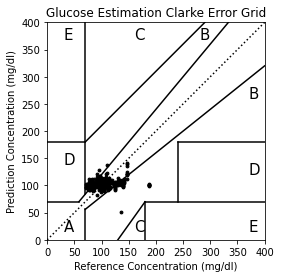

In [57]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [58]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = 85, random_state = 7)
trainTest(model)

MAPE: 86.39
MAE: 14.35
RMSE: 20.34


20.34

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [211, 71, 0, 0, 0])

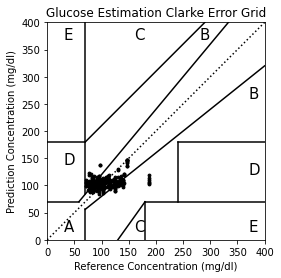

In [59]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [60]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
trainTest(model)

MAPE: 81.81
MAE: 18.37
RMSE: 26.88


26.88

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [177, 104, 1, 0, 0])

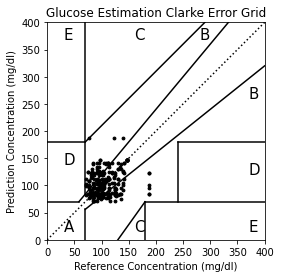

In [61]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [62]:
from sklearn.linear_model import ElasticNet

model = ElasticNet()
trainTest(model)

MAPE: 84.41
MAE: 16.1
RMSE: 21.77


21.77

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [196, 86, 0, 0, 0])

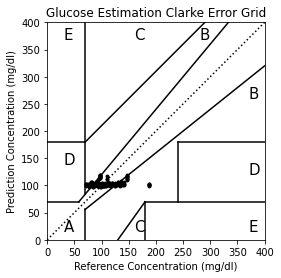

In [63]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [64]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=11,p=2,weights='distance')
trainTest(model)

MAPE: 85.77
MAE: 14.62
RMSE: 21.37


21.37

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [206, 76, 0, 0, 0])

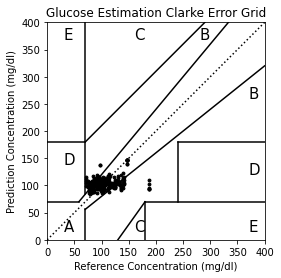

In [65]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [66]:
from sklearn.svm import SVR

model = SVR()
trainTest(model)

MAPE: 83.44
MAE: 16.25
RMSE: 23.14


23.14

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [198, 84, 0, 0, 0])

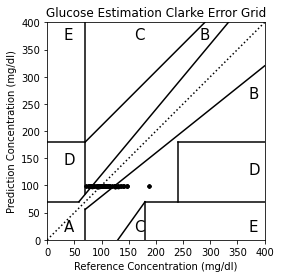

In [67]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [68]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=2)
trainTest(model)

MAPE: 84.43
MAE: 16.08
RMSE: 21.78


21.78

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [197, 85, 0, 0, 0])

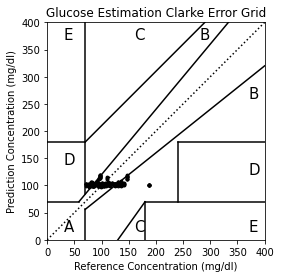

In [69]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [70]:
from sklearn.linear_model import BayesianRidge

model = BayesianRidge(n_iter=1)
trainTest(model)

MAPE: 84.37
MAE: 16.14
RMSE: 21.77


21.77

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [198, 84, 0, 0, 0])

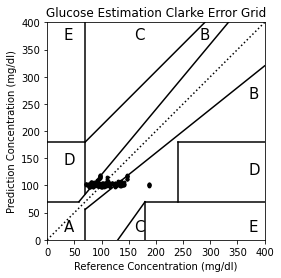

In [71]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [72]:
from sklearn.linear_model import TweedieRegressor

model = TweedieRegressor(power=1,alpha=0,max_iter=75)
trainTest(model)

MAPE: 84.06
MAE: 16.41
RMSE: 22.05


22.05

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [191, 91, 0, 0, 0])

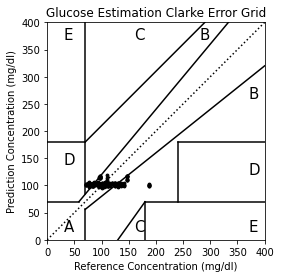

In [73]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [74]:
from sklearn.ensemble import HistGradientBoostingRegressor

model = HistGradientBoostingRegressor()
trainTest(model)

MAPE: 85.91
MAE: 14.83
RMSE: 20.65


20.65

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [209, 73, 0, 0, 0])

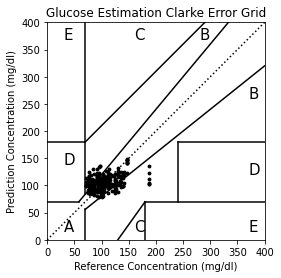

In [75]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [76]:
from sklearn.ensemble import AdaBoostRegressor

rfr = RandomForestRegressor(n_estimators = 85, random_state = 7)
model = AdaBoostRegressor(base_estimator=rfr,n_estimators=65,learning_rate=0.05,random_state=7)
trainTest(model)

MAPE: 86.36
MAE: 14.36
RMSE: 20.26


20.26

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [208, 74, 0, 0, 0])

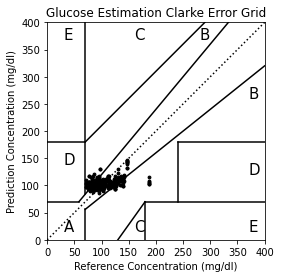

In [77]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [78]:
knn = KNeighborsRegressor(n_neighbors=9,p=1,weights='distance')
model = AdaBoostRegressor(base_estimator=knn,n_estimators=65,learning_rate=0.05,random_state=10)
trainTest(model)

MAPE: 85.73
MAE: 14.79
RMSE: 21.33


21.33

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [208, 74, 0, 0, 0])

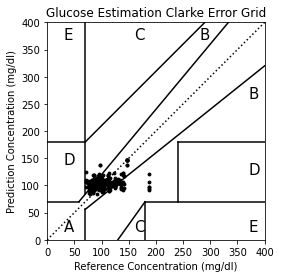

In [79]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [80]:
#Testing This Dataset Combined with Red Dataset from Previous Notebook
dataset = pd.read_csv('red_data_second.csv')
x_train, x_test, y_train, y_test = train_test_split(dataset.drop(columns=['Glucose']), dataset[['Glucose']].astype('float') ,test_size=0.25,random_state=7)
x_train

,0,1,2,3,4,5,6,7,8,9,...,Blue Variance,Gray COM,Gray Minimum,Gray Median,Gray Mean,Gray SDT,Gray Variance,Inertia Eigen Val1,Inertia Eigen Val2,Inertia Eigen Val3
294,0,0,0,0,0,0,0,0,0,0,...,5344.812907,0.288251,0.033922,0.217583,0.208144,0.054338,0.002953,42796.46147,25767.07247,17030.42753
821,0,0,0,0,0,0,0,0,0,0,...,6017.749756,0.289716,0.079525,0.229127,0.226885,0.042169,0.001778,44977.93478,27744.99805,17234.14759
403,0,0,0,0,0,0,0,0,0,0,...,4929.335312,0.295602,0.085165,0.226405,0.225108,0.043410,0.001884,44766.59157,27550.32872,17217.50106
597,0,0,0,0,0,0,0,0,0,0,...,5374.229990,0.293638,0.098529,0.229923,0.227542,0.042316,0.001791,45012.64020,27726.82575,17287.06896
929,0,0,0,0,0,0,0,0,0,0,...,5179.008594,0.292775,0.041667,0.212609,0.209620,0.053103,0.002820,42959.14222,25969.84644,16990.43018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,0,0,0,0,0,0,0,0,0,0,...,4525.858164,0.291100,0.076696,0.213185,0.216388,0.046411,0.002154,44249.26723,27255.42797,16995.05389
211,0,0,0,0,0,0,0,0,0,0,...,1648.640100,0.267402,0.052843,0.156628,0.170088,0.054839,0.003007,40837.02478,24826.14517,16011.96456
502,0,0,0,0,0,0,0,0,0,0,...,6069.300337,0.293109,0.109219,0.240206,0.234272,0.038788,0.001505,45486.30757,28112.10280,17375.43134
537,0,0,0,0,0,0,0,0,0,0,...,4943.129941,0.291100,0.083684,0.218433,0.220105,0.044946,0.002020,44527.78440,27479.63661,17049.35923


In [81]:
model = RandomForestRegressor(n_estimators=137,criterion='absolute_error',min_samples_split=3,random_state=7)
trainTest(model)

MAPE: 87.6
MAE: 12.99
RMSE: 18.24


18.24

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [218, 64, 0, 0, 0])

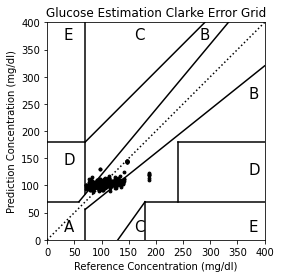

In [82]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [83]:
model = ElasticNet()
trainTest(model)

MAPE: 83.98
MAE: 16.31
RMSE: 21.38


21.38

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [193, 89, 0, 0, 0])

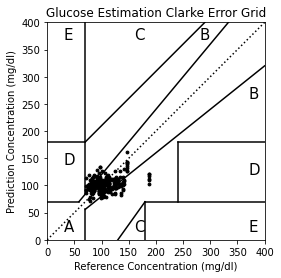

In [84]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [85]:
model = KNeighborsRegressor(n_neighbors=4,p=1,weights='distance',metric='minkowski')
trainTest(model)

MAPE: 90.3
MAE: 10.01
RMSE: 15.38


15.38

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [234, 48, 0, 0, 0])

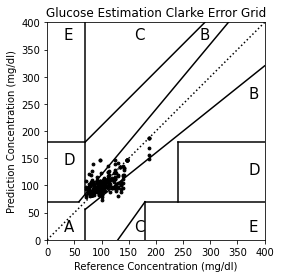

In [86]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [87]:
from xgboost import XGBRegressor
model = XGBRegressor(eta=0.1,gamma=1.9,min_child_weight=2,tree_method='approx')
trainTest(model)

MAPE: 87.76
MAE: 12.61
RMSE: 18.36


18.36

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [220, 62, 0, 0, 0])

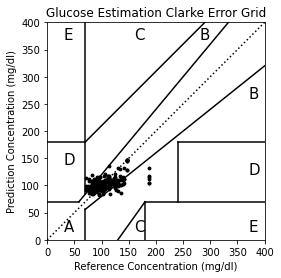

In [88]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [89]:
from sklearn.ensemble import HistGradientBoostingRegressor
model = HistGradientBoostingRegressor(loss='squared_error',learning_rate=0.08)
trainTest(model)

MAPE: 86.91
MAE: 13.54
RMSE: 19.15


19.15

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [219, 63, 0, 0, 0])

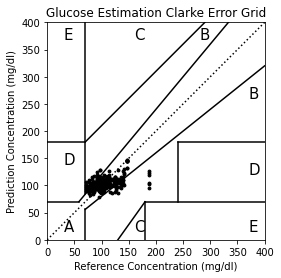

In [90]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [91]:
#Used to Find the Best Value for N-Neighbors

'''

from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=4,p=1,weights='distance',metric='minkowski')
c = 0
oldacc = 100
for x in range(1,75):
    model = AdaBoostRegressor(base_estimator=knn,n_estimators=x,learning_rate=1,random_state=10)
    acc = trainTest(model)
    if acc < oldacc:
        c = x
        oldacc = acc
print(c)

'''

"\n\nfrom sklearn.ensemble import AdaBoostRegressor\nfrom sklearn.neighbors import KNeighborsRegressor\nknn = KNeighborsRegressor(n_neighbors=4,p=1,weights='distance',metric='minkowski')\nc = 0\noldacc = 100\nfor x in range(1,75):\n    model = AdaBoostRegressor(base_estimator=knn,n_estimators=x,learning_rate=1,random_state=10)\n    acc = trainTest(model)\n    if acc < oldacc:\n        c = x\n        oldacc = acc\nprint(c)\n\n"

In [92]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=4,p=1,weights='distance',metric='minkowski')
model = AdaBoostRegressor(base_estimator=knn,n_estimators=9,learning_rate=1,random_state=10)
trainTest(model)

MAPE: 90.55
MAE: 9.66
RMSE: 14.81


14.81

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [237, 45, 0, 0, 0])

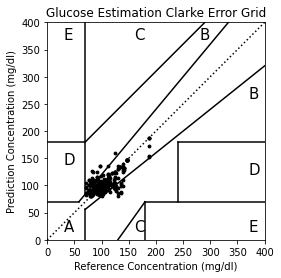

In [93]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [94]:
#Testing Different Scalers with This Model

In [95]:
from sklearn.preprocessing import StandardScaler
dataset = pd.read_csv('red_data_second.csv')
scaler = StandardScaler()
features = dataset.columns.to_numpy()[0:256].astype(str).tolist()
features2 = dataset.columns.to_numpy()[257:285].tolist()
feature3 = features + features2
for feature in feature3:
    dataset[[feature]] = scaler.fit_transform(dataset[[feature]])
x_train, x_test, y_train, y_test = train_test_split(dataset.drop(columns=['Glucose']), dataset[['Glucose']].astype('float') ,test_size=0.25,random_state=7)
x_train


,0,1,2,3,4,5,6,7,8,9,...,Blue Variance,Gray COM,Gray Minimum,Gray Median,Gray Mean,Gray SDT,Gray Variance,Inertia Eigen Val1,Inertia Eigen Val2,Inertia Eigen Val3
294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.172131,-0.410646,-3.042688,-0.504205,-1.264670,2.599940,2.631304,-1.907547,-2.307522,-0.599710
821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.959241,-0.134671,-0.497598,0.247153,0.284011,-0.367426,-0.374055,0.350214,0.388339,0.213356
403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.313838,0.973734,-0.182788,0.069973,0.137163,-0.064758,-0.102221,0.131480,0.123010,0.146918
597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.206539,0.603822,0.563046,0.298940,0.338322,-0.331395,-0.342107,0.386133,0.363571,0.424570
929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.021804,0.441280,-2.610438,-0.827952,-1.142720,2.298937,2.291906,-1.739177,-2.031146,-0.759343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.785771,0.125943,-0.655440,-0.790408,-0.583409,0.667033,0.587593,-0.403936,-0.278932,-0.740890
211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4.151148,-4.336919,-1.986684,-4.471361,-4.409555,2.722248,2.771441,-3.935506,-3.589982,-4.664492
502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.019538,0.504273,1.159639,0.968178,0.894465,-1.191778,-1.074438,0.876365,0.888693,0.777233
537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.297703,0.125943,-0.265496,-0.448859,-0.276256,0.309896,0.245182,-0.115679,0.026658,-0.524152


In [96]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
knn = KNeighborsRegressor(n_neighbors=4,p=1,weights='distance',metric='minkowski')
model = AdaBoostRegressor(base_estimator=knn,n_estimators=9,learning_rate=1,random_state=10)
trainTest(model)

MAPE: 89.7
MAE: 10.73
RMSE: 15.78


15.78

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [238, 44, 0, 0, 0])

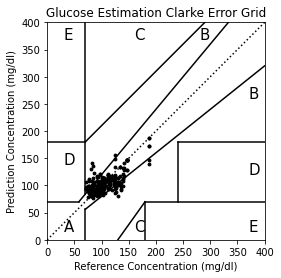

In [97]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [98]:
from sklearn.preprocessing import MinMaxScaler
dataset = pd.read_csv('red_data_second.csv')
scaler = MinMaxScaler()
features = dataset.columns.to_numpy()[0:256].astype(str).tolist()
features2 = dataset.columns.to_numpy()[257:285].tolist()
feature3 = features + features2
for feature in feature3:
    dataset[[feature]] = scaler.fit_transform(dataset[[feature]])
x_train, x_test, y_train, y_test = train_test_split(dataset.drop(columns=['Glucose']), dataset[['Glucose']].astype('float') ,test_size=0.25,random_state=7)
x_train

,0,1,2,3,4,5,6,7,8,9,...,Blue Variance,Gray COM,Gray Minimum,Gray Median,Gray Mean,Gray SDT,Gray Variance,Inertia Eigen Val1,Inertia Eigen Val2,Inertia Eigen Val3
294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.693496,0.586808,0.011668,0.642069,0.531917,0.774360,0.728277,0.377215,0.277204,0.653474
821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.813413,0.628055,0.478889,0.757152,0.773786,0.288355,0.234233,0.758339,0.753131,0.779306
403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.619458,0.793713,0.536680,0.730014,0.750852,0.337927,0.278919,0.721416,0.706290,0.769024
597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.698738,0.738427,0.673599,0.765084,0.782268,0.294257,0.239485,0.764403,0.748758,0.811994
929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.663950,0.714134,0.091019,0.592482,0.550963,0.725061,0.672484,0.405637,0.325995,0.628769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.547559,0.667005,0.449912,0.598232,0.638315,0.457782,0.392316,0.631034,0.635331,0.631624
211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.034841,0.000000,0.205526,0.034433,0.040757,0.794392,0.751313,0.034882,0.050798,0.024398
502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.822599,0.723549,0.783120,0.867589,0.869125,0.153340,0.119099,0.847157,0.841463,0.866573
537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.621916,0.667005,0.521497,0.650546,0.686285,0.399289,0.336028,0.679694,0.689280,0.665167


In [99]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
knn = KNeighborsRegressor(n_neighbors=4,p=1,weights='distance',metric='minkowski')
model = AdaBoostRegressor(base_estimator=knn,n_estimators=9,learning_rate=1,random_state=10)
trainTest(model)

MAPE: 87.32
MAE: 12.95
RMSE: 19.04


19.04

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [218, 64, 0, 0, 0])

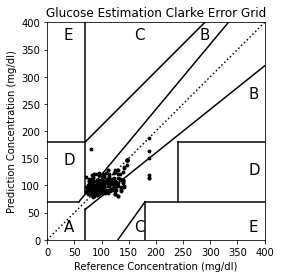

In [100]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [101]:
from sklearn.preprocessing import RobustScaler
dataset = pd.read_csv('red_data_second.csv')
scaler = RobustScaler()
features = dataset.columns.to_numpy()[0:256].astype(str).tolist()
features2 = dataset.columns.to_numpy()[257:285].tolist()
feature3 = features + features2
for feature in feature3:
    dataset[[feature]] = scaler.fit_transform(dataset[[feature]])
x_train, x_test, y_train, y_test = train_test_split(dataset.drop(columns=['Glucose']), dataset[['Glucose']].astype('float') ,test_size=0.25,random_state=7)
x_train

,0,1,2,3,4,5,6,7,8,9,...,Blue Variance,Gray COM,Gray Minimum,Gray Median,Gray Mean,Gray SDT,Gray Variance,Inertia Eigen Val1,Inertia Eigen Val2,Inertia Eigen Val3
294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.062834,-0.638350,-4.116631,-1.502577,-3.621045,5.167605,5.873735,-5.073120,-6.065618,-1.973007
821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.362847,-0.311746,-0.929873,0.069866,0.091935,-0.202280,-0.201066,0.168817,0.244588,-0.057490
403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.739806,1.000000,-0.535694,-0.300937,-0.260135,0.345442,0.348397,-0.339027,-0.376469,-0.214012
597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.119664,0.562227,0.398180,0.178244,0.222146,-0.137076,-0.136489,0.252212,0.186612,0.440114
929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.257475,0.369865,-3.575402,-2.180114,-3.328668,4.622896,5.187701,-4.682208,-5.418705,-2.349090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.519263,-0.003321,-1.127511,-2.101541,-1.987715,1.669726,1.742735,-1.582123,-1.317295,-2.305615
211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7.077617,-5.284915,-2.794388,-9.805037,-11.160944,5.388939,6.156996,-9.781517,-9.067472,-11.549304
502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.462435,0.444415,1.145186,1.578826,1.555506,-1.694066,-1.616767,1.390403,1.415767,1.270958
537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.713157,-0.003321,-0.639254,-1.386748,-1.251312,1.023434,1.050612,-0.912865,-0.601999,-1.794998


In [102]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
knn = KNeighborsRegressor(n_neighbors=4,p=1,weights='distance',metric='minkowski')
model = AdaBoostRegressor(base_estimator=knn,n_estimators=9,learning_rate=1,random_state=10)
trainTest(model)

MAPE: 89.49
MAE: 11.1
RMSE: 16.43


16.43

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [232, 50, 0, 0, 0])

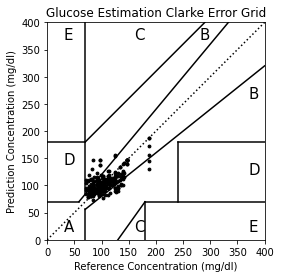

In [103]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [104]:
from sklearn.preprocessing import MaxAbsScaler
dataset = pd.read_csv('red_data_second.csv')
scaler = MaxAbsScaler()
features = dataset.columns.to_numpy()[0:256].astype(str).tolist()
features2 = dataset.columns.to_numpy()[257:285].tolist()
feature3 = features + features2
for feature in feature3:
    dataset[[feature]] = scaler.fit_transform(dataset[[feature]])
x_train, x_test, y_train, y_test = train_test_split(dataset.drop(columns=['Glucose']), dataset[['Glucose']].astype('float') ,test_size=0.25,random_state=7)
x_train

,0,1,2,3,4,5,6,7,8,9,...,Blue Variance,Gray COM,Gray Minimum,Gray Median,Gray Mean,Gray SDT,Gray Variance,Inertia Eigen Val1,Inertia Eigen Val2,Inertia Eigen Val3
294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.756539,0.951538,0.260159,0.858354,0.851610,0.905818,0.820506,0.923111,0.895593,0.968108
821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.851791,0.956375,0.609909,0.903896,0.928287,0.702959,0.494151,0.970164,0.964340,0.979689
403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.697730,0.975805,0.653170,0.893157,0.921016,0.723650,0.523670,0.965606,0.957574,0.978743
597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.760703,0.969321,0.755664,0.907035,0.930976,0.705422,0.497621,0.970913,0.963708,0.982697
929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.733070,0.966471,0.319559,0.838730,0.857648,0.885240,0.783650,0.926620,0.902641,0.965835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.640619,0.960944,0.588218,0.841006,0.885340,0.773678,0.598577,0.954447,0.947324,0.966098
211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.233359,0.882712,0.405277,0.617891,0.695904,0.914179,0.835723,0.880846,0.862889,0.910213
502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.859087,0.967576,0.837649,0.947600,0.958511,0.646604,0.418096,0.981130,0.977100,0.987720
537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.699682,0.960944,0.641805,0.861709,0.900547,0.749263,0.561395,0.960455,0.955117,0.969185


In [105]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
knn = KNeighborsRegressor(n_neighbors=5,p=1,weights='distance',metric='minkowski')
model = AdaBoostRegressor(base_estimator=knn,n_estimators=9,learning_rate=1,random_state=10)
trainTest(model)

MAPE: 86.39
MAE: 14.08
RMSE: 19.95


19.95

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [209, 73, 0, 0, 0])

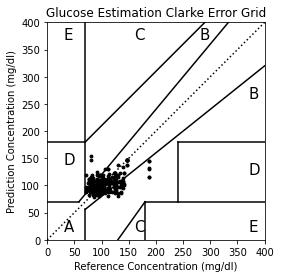

In [106]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [107]:
#Saving Final Model with Original Settings

In [108]:
dataset = pd.read_csv('red_data_second.csv')
x_train, x_test, y_train, y_test = train_test_split(dataset.drop(columns=['Glucose']), dataset[['Glucose']].astype('float') ,test_size=0.25,random_state=7)
x_train

,0,1,2,3,4,5,6,7,8,9,...,Blue Variance,Gray COM,Gray Minimum,Gray Median,Gray Mean,Gray SDT,Gray Variance,Inertia Eigen Val1,Inertia Eigen Val2,Inertia Eigen Val3
294,0,0,0,0,0,0,0,0,0,0,...,5344.812907,0.288251,0.033922,0.217583,0.208144,0.054338,0.002953,42796.46147,25767.07247,17030.42753
821,0,0,0,0,0,0,0,0,0,0,...,6017.749756,0.289716,0.079525,0.229127,0.226885,0.042169,0.001778,44977.93478,27744.99805,17234.14759
403,0,0,0,0,0,0,0,0,0,0,...,4929.335312,0.295602,0.085165,0.226405,0.225108,0.043410,0.001884,44766.59157,27550.32872,17217.50106
597,0,0,0,0,0,0,0,0,0,0,...,5374.229990,0.293638,0.098529,0.229923,0.227542,0.042316,0.001791,45012.64020,27726.82575,17287.06896
929,0,0,0,0,0,0,0,0,0,0,...,5179.008594,0.292775,0.041667,0.212609,0.209620,0.053103,0.002820,42959.14222,25969.84644,16990.43018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,0,0,0,0,0,0,0,0,0,0,...,4525.858164,0.291100,0.076696,0.213185,0.216388,0.046411,0.002154,44249.26723,27255.42797,16995.05389
211,0,0,0,0,0,0,0,0,0,0,...,1648.640100,0.267402,0.052843,0.156628,0.170088,0.054839,0.003007,40837.02478,24826.14517,16011.96456
502,0,0,0,0,0,0,0,0,0,0,...,6069.300337,0.293109,0.109219,0.240206,0.234272,0.038788,0.001505,45486.30757,28112.10280,17375.43134
537,0,0,0,0,0,0,0,0,0,0,...,4943.129941,0.291100,0.083684,0.218433,0.220105,0.044946,0.002020,44527.78440,27479.63661,17049.35923


In [109]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=4,p=1,weights='distance',metric='minkowski')
model = AdaBoostRegressor(base_estimator=knn,n_estimators=9,learning_rate=1,random_state=10)
trainTest(model)

MAPE: 90.55
MAE: 9.66
RMSE: 14.81


14.81

(<module 'matplotlib.pyplot' from 'c:\\Users\\Kazi\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [237, 45, 0, 0, 0])

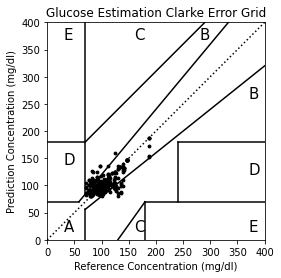

In [110]:
from ClarkeErrorGrid import clarke_error_grid
preds = model.predict(x_test)
act = y_test.to_numpy()
clarke_error_grid(act,preds,'Glucose Estimation')

In [111]:
import pickle
pickle.dump(model, open('second_final_model.sav', 'wb'))